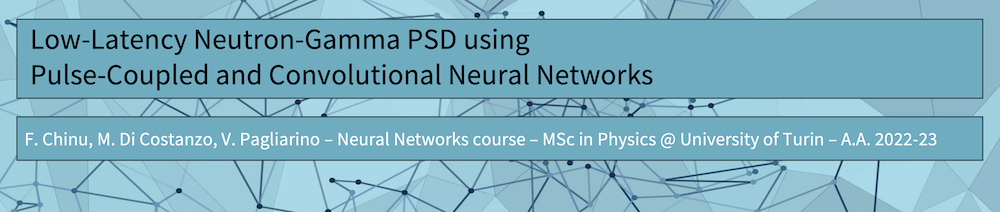

# HLS4ML - Model quantization, pruning and optimization for hardware implementation

In this notebook the model is pruned using a polynomial decay algorithm and is quantized and implemented on FPGA hardware using the HLS4ML package.

Pruning of the model is not applied linearly (i.e. the number of parameters set to 0 does not increse proportionally to the number of epochs); instead, a polynomial decay algorithm is used: the sparsity increases as:
<center>     $ S(t) = S_f + (S_i-S_f)\left(1-\frac{t-t_0}{n\Delta_t}\right)^{\alpha} $

Where $ S(t) $ is the sparsity level at the t-th pruning iteration, $S_f$ is the desired final sparsity (set to 70% in our case), $S_i$ is the initial sparsity (0% in our case), n is the total number of pruning steps (10 epochs in our case), starting at training step $t_0$ and with pruning frequency $\Delta_t$.

The quantization of the model is needed for its harware implementation and consists in converting the floating point weights, which are used in our computers, in fixed point numbers, which can be handled by the FPGA electronics. The quantized model uses 16 bits for representing a number, of which 6 bits are used for the integer part while the remaining 10 are used for the fracional part of the number

In [6]:
# Use Python 3.8.10 on UNITO HPC4AI MLJC computing node - Tensorflow supporting GPU with libcudart.so.10.1
import numpy as np
np.random.seed(19)
import random
import time

import scipy as sp
from scipy.io import loadmat
#from scipy.fft import *
#from scipy.signal import convolve2d

import pandas as pd
import pickle

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) #Disable TF Warnings
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras import regularizers
import tensorflow_model_optimization as tfmot

import keras
import keras_tuner
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils.vis_utils import plot_model
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from sklearn.metrics import accuracy_score


import visualkeras
import pydot
import graphviz
from PIL import ImageFont

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

if tf.config.list_physical_devices('GPU'):
    print('GPU is available! (', tf.config.list_physical_devices(), ")")
else:
    print('GPU not properly loaded! Training is going to run on CPU')

GPU is available! ( [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] )


### Read the trained model from storage

In [7]:
input_shape = (240, 1)  

# CNN 1D
model = Sequential()
filtersnum1 = 4
ksize = 6

model.add(Conv1D(filtersnum1, 
            kernel_size=ksize, 
            activation='relu', input_shape=input_shape))

model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filtersnum1 * 2, 
            kernel_size=ksize, 
            activation='relu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
    
l1regularization = 5e-5
model.add(Dense(34,
                   activation='relu', 
                   kernel_regularizer=regularizers.L1L2(l1=l1regularization, 
                                                        l2=0.0)))

model.add(Dense(1, activation='sigmoid', name="dense_out"))

# Minimizer
optim = keras.optimizers.Adam(learning_rate = 0.001)

# Compile
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

model.load_weights('./model/fullTraining.h5')

### Model pruning

In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(1865) #0.9  
print('Number of training steps per epoch is {}'.format(NSTEPS))


## Prune all convolutional and dense layers gradually from 0 to 70% sparsity,
## ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.70, begin_step=NSTEPS * 0, end_step=NSTEPS * 30, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv1D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'dense_out':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)
model_pruned.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

Number of training steps per epoch is 1865


In [ ]:
model_pruned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv1d_  (None, 235, 4)           54        
 2 (PruneLowMagnitude)                                           
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 117, 4)           0         
 1D)                                                             
                                                                 
 prune_low_magnitude_conv1d_  (None, 112, 8)           394       
 3 (PruneLowMagnitude)                                           
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 56, 8)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 448)              

### Importing Dataset 3 for training the pruned model

In [21]:
with open('./arrays/dataset3_PCNN_Out_loose.p', 'rb') as handle:
    trainingSetDict = pickle.load(handle)

trainSetGamma = trainingSetDict['raw_gamma']
trainSetNeutron = trainingSetDict['raw_neutron']

trainSetGamma = trainSetGamma[0:min(len(trainSetGamma),len(trainSetNeutron))]
trainSetNeutron = trainSetNeutron[0:min(len(trainSetGamma),len(trainSetNeutron))]

### ENCODING! 0 = Gamma, 1 = Neutron
trainingSetValues = np.vstack((trainSetGamma, trainSetNeutron))
trainingSetLabels = np.array([0,] * len(trainSetGamma) + [1,] * len(trainSetNeutron))

### Data augmentation with negative polarity pulses
trainingSetValues = np.vstack((trainingSetValues,trainingSetValues*-1.0))
trainingSetLabels = np.tile(trainingSetLabels, (1,2)).transpose()


### Require traslational invariance
for i in range(len(trainingSetValues)):
    ### WARNING!!! DISABLE THIS FOR SPATIAL ATTENTION ANALYSIS ACROSS MINIBATCHES!
    shift = random.randint(-60, 180)
    trainingSetValues[i] = np.roll(trainingSetValues[i], shift)

trainingSetValues, trainingSetLabels = shuffle(trainingSetValues, trainingSetLabels, random_state=4)

### TrainValid / Test separation
trainValidValues, testSetValues, trainValidLabels, testSetLabels = train_test_split(trainingSetValues, trainingSetLabels, test_size=0.1, random_state=1900234578)

test_set = {'testVal' : testSetValues, 'testLab' : testSetLabels}

with open('./model/testSetp.p', 'wb') as handle:
    pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL);

### Training / Validation separation
X_train, X_val, y_train, y_val = train_test_split(trainValidValues, trainValidLabels, test_size=0.4, random_state=1989234578)
dt3 = X_train
dt3l = y_train

### Train the pruned model

Epoch 1/30


2023-07-04 09:49:02.769812: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-04 09:49:04.364738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8202
2023-07-04 09:49:05.063634: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1865/1865 [==============================] - 31s 13ms/step - loss: 0.0118 - accuracy: 0.9987 - val_loss: 0.1208 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/30
1865/1865 [==============================] - 24s 13ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.0112 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 3/30
1865/1865 [==============================] - 25s 14ms/step - loss: 0.0105 - accuracy: 0.9991 - val_loss: 0.0116 - val_accuracy: 0.9988 - lr: 0.0010
Epoch 4/30
1865/1865 [==============================] - 24s 13ms/step - loss: 0.0103 - accuracy: 0.9991 - val_loss: 0.0317 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 5/30
1862/1865 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9988
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1865/1865 [==============================] - 29s 15ms/step - loss: 0.0108 - accuracy: 0.9988 - val_loss: 0.0975 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 6/30
1865/1865 [==============================]

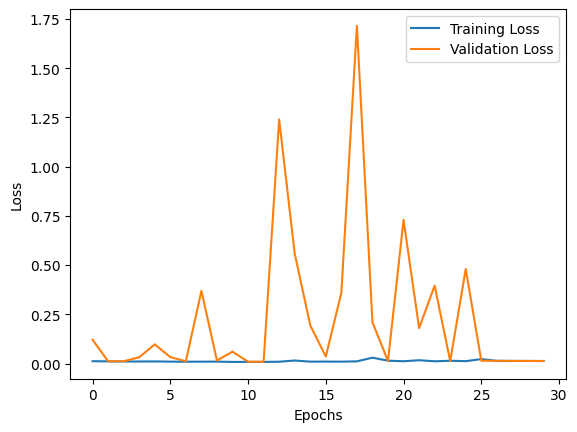

In [22]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    pruning_callbacks.UpdatePruningStep(),
]

tf.autograph.set_verbosity(0, False)
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

# Start the training process
history = model_pruned.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=60, callbacks=callbacks)
model_pruned.save_weights('./model/fullTrainingPruned.h5')

# Plot loss function for training and validation set
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
model_pruned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv1d_  (None, 235, 4)           54        
 2 (PruneLowMagnitude)                                           
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 117, 4)           0         
 1D)                                                             
                                                                 
 prune_low_magnitude_conv1d_  (None, 112, 8)           394       
 3 (PruneLowMagnitude)                                           
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 56, 8)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 448)              

### Distribution of the weight values aftre the model pruning

After the model has been pruned, we checked the sparsity level by plotting the distribution of the weight values; as expected, a lot of weights are set to 0; more precisely, ~70% of the weights are set to 0, which is compatible with the final sparsity that was set in the pruning function

% of zeros = 0.6999737394957983


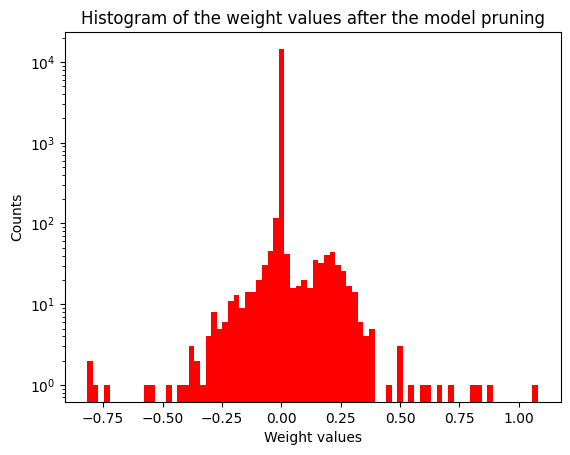

In [20]:
fig, ax = plt.subplots()
model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)
model_pruned.load_weights('./model/fullTrainingPruned.h5')
w = model_pruned.layers[-2].weights[0].numpy()

ax.hist(w.flatten(), bins=80, color="red")
ax.set_title("Histogram of the weight values after the model pruning")
ax.set_xlabel("Weight values")
ax.set_ylabel("Counts")
ax.set_yscale('log')

print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

### Introduce the HLS4ML Framework for model quantization and synthesis

Here the model is quantized and syntetized using the HLS4ML framework. The quantization happens by dropping the floating point representation of a number, in favour of a fixed point representation. The representation being used will be <16,6>, where the first number is the total number of bits being used to handle the weighs and the neurons activations, while the second is the number of bits used for the integer part

In [36]:
#### SETUP VIVADO HIGH LEVEL SYNTHESIS PATH ###
##os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
###############################################

import hls4ml
model_stripped = strip_pruning(model_pruned)
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model_stripped,
                                                       hls_config=config,
                                                       output_dir='model_hls/hls4ml_prj',
                                                       part='XC7Z020-1CLG484C')

Interpreting Sequential
Topology:
Layer name: conv1d_2_input, layer type: InputLayer, input shapes: [[None, 240, 1]], output shape: [None, 240, 1]
Layer name: conv1d_2, layer type: Conv1D, input shapes: [[None, 240, 1]], output shape: [None, 235, 4]
Layer name: max_pooling1d_2, layer type: MaxPooling1D, input shapes: [[None, 235, 4]], output shape: [None, 117, 4]
Layer name: conv1d_3, layer type: Conv1D, input shapes: [[None, 117, 4]], output shape: [None, 112, 8]
Layer name: max_pooling1d_3, layer type: MaxPooling1D, input shapes: [[None, 112, 8]], output shape: [None, 56, 8]
Layer name: flatten_1, layer type: Reshape, input shapes: [[None, 56, 8]], output shape: [None, 448]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 448]], output shape: [None, 34]
Layer name: dense_out, layer type: Dense, input shapes: [[None, 34]], output shape: [None, 1]
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer n

Writing HLS project
Done


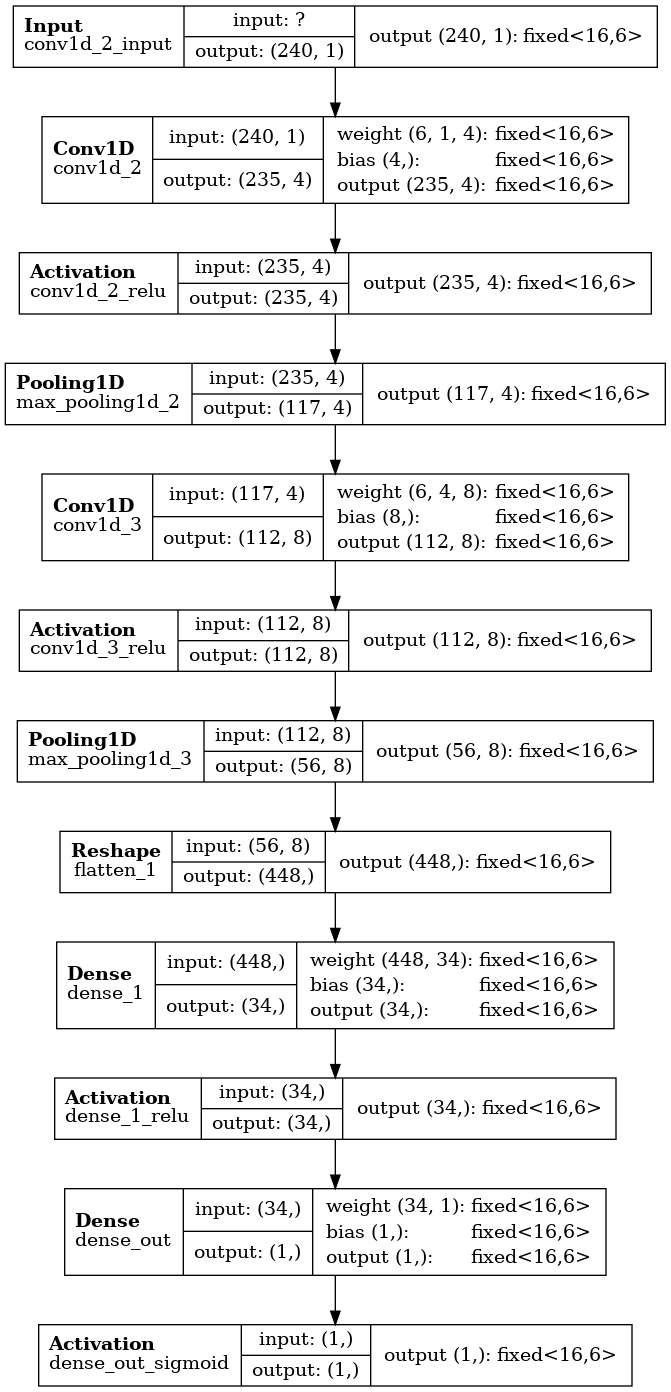

In [53]:
hls_model.compile()
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

### Load the test dataset for model evaluation

Here the quantized model performance is evaluated; a drop in accuracy is expected since the amount of bits used to represent the numbers is reduced

In [54]:
with open('./model/testSetp.p', 'rb') as handle:
    dataset_dict = pickle.load(handle)
    
testSetValues = dataset_dict['testVal']
testSetLabels = dataset_dict['testLab']

### Create two separate test datasets
test1Val, test2Val, test1Lab, test2Lab = train_test_split(testSetValues, testSetLabels, test_size=0.5, random_state=234)

X_test = test1Val

In [55]:
#X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

In [100]:
fp = 0
fn = 0
err_tot = 0
val_tot = len(y_hls)

for i in range(len(y_hls)):
    if((y_hls[i].round() == 0) and (test1Lab[i].round() == 1)):
        fp = fp + 1 
    if((y_hls[i].round() == 1) and (test1Lab[i].round() == 0)):
        fn = fn + 1 

err_tot = fn + fp
accuracy = 1. - err_tot / val_tot
false_pos = fp / val_tot
false_neg = fn / val_tot
print("Accuracy = {},  False positive = {}, False negative = {}, items = {}".format(accuracy, false_pos, false_neg, len(y_hls)))

Accuracy = 0.975871054917479,  False positive = 0.020461345429977802, False negative = 0.0036675996525431906, items = 10361


### Run Vivado High Level Synthesis and produce the RTL IP core

In [ ]:
hls_model.build(csim=False)

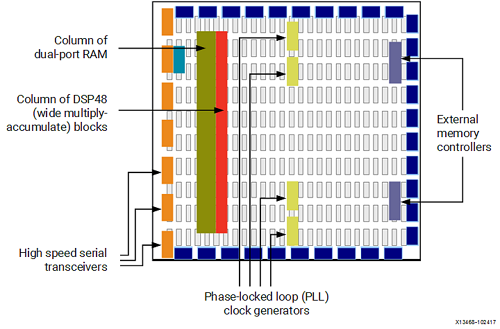

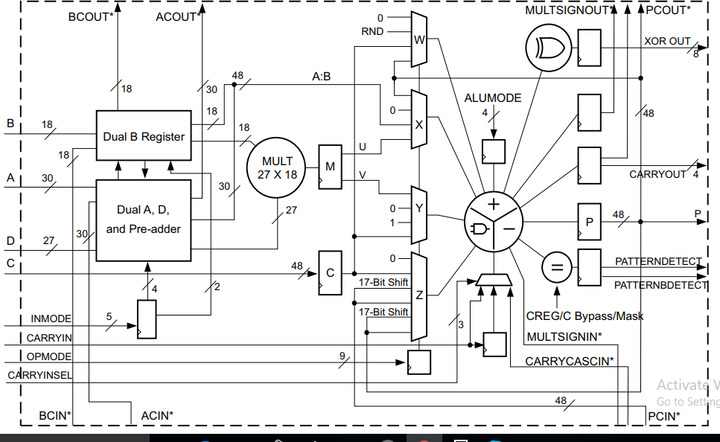